# analyze_metadata_table

This notebook builds on the previously produced data table, performs QC, and adds meta-features for visualization.

In [1]:
# import required modules
import numpy as np
import pandas as pd
from collections import Counter
import statistics

import datetime
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

### Import data

In [2]:
# import table from create_metadata_table.ipynb
allFactors = pd.read_csv('../data_tables/metadataMatrix_raw.csv', low_memory=False)

### Conduct analysis on this table, producing new metrics

In [3]:
# add a column with the total use count of each converted_accession ID

# first, create a new dataframe with no double-counted accessions
# justAcc includes all unique pairings of PMC ID and Series/Study accession
justAcc = allFactors.loc[:, ['pmc_ID', 'converted_accession']]
justAcc = justAcc.drop_duplicates()

rc = Counter(justAcc['converted_accession'])
reuse_counts = pd.DataFrame.from_dict(rc, orient = 'index').reset_index()
reuse_counts.columns = ['converted_accession', 'total_use_count']
reuse_counts

,converted_accession,total_use_count
0,GSE506,217
1,GSE45534,1
2,GSE5281,109
3,GSE67036,1
4,GSE1297,66
...,...,...
85069,SRP121519,1
85070,GSE57504,1
85071,GSE16963,1
85072,GSE17818;GSE17895,1


In [4]:
# merge reuse counts onto table
allFactors = pd.merge(allFactors, reuse_counts, how = 'left', on = 'converted_accession')
allFactors

,journal,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,total_use_count
0,Alzheimers_Res_Ther,PMC3707052,GSM1,GSE506,GEO,2013-04-18,2003-07-16,Homo sapiens,SAGE NlaIII,Expression_Array,NaN,NaN,NaN,217
1,Alzheimers_Res_Ther,PMC3706879,GSE45534,GSE45534,GEO,2013-05-14,2013-03-28,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,1
2,Alzheimers_Res_Ther,PMC4255636,GSE5281,GSE5281,GEO,2014-11-02,2006-07-10,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,109
3,Alzheimers_Res_Ther,PMC4731966,GSE67036,GSE67036,GEO,2016-01-28,2016-03-17,Rattus norvegicus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,1
4,Alzheimers_Res_Ther,PMC4731966,GSE1297,GSE1297,GEO,2016-01-28,2004-07-16,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223959,Saudi_J_Biol_Sci,PMC6088103,GSE28146,GSE28146,GEO,2018-05-18,2011-08-01,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,33
223960,Saudi_J_Biol_Sci,PMC6933160,ERS2923991,ERP109196,SRA,2019-05-07,2019-01-24,metagenome,454 GS FLX,AMPLICON,250.0,6461726.0,public,1
223961,Saudi_J_Biol_Sci,PMC6933160,ERS2923992,ERP109196,SRA,2019-05-07,2019-01-24,metagenome,454 GS FLX,AMPLICON,250.0,6461726.0,public,1
223962,Saudi_J_Biol_Sci,PMC6933160,ERS2923995,ERP109196,SRA,2019-05-07,2019-01-24,metagenome,454 GS FLX,AMPLICON,250.0,6461726.0,public,1


In [5]:
# normalize reuse count by amount of time public

# convert repository upload dates and today's date to datetime objects
allFactors.loc[:,'repository_date'] = allFactors['repository_date'].replace({' ':''})
fmt = '%Y-%m-%d'
allFactors.loc[:,'repository_date'] = pd.to_datetime(allFactors['repository_date'], format = fmt)
allFactors['today'] = date.today().strftime(fmt)
allFactors['today'] = pd.to_datetime(allFactors['today'], format = fmt)

# create timedelta objects representing amount of time public in YEARS
allFactors['time_public'] = allFactors['today'] - allFactors['repository_date']
allFactors['time_public'] = allFactors['time_public'].dt.days / 365

# normalize reuse count by years public
allFactors['reuse_count'] = (allFactors['total_use_count'] - 1)
allFactors['norm_reuse_count'] = allFactors['reuse_count'] / allFactors['time_public']
allFactors = allFactors.drop(labels = ['total_use_count'], axis = 1)
allFactors

,journal,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,today,time_public,reuse_count,norm_reuse_count
0,Alzheimers_Res_Ther,PMC3707052,GSM1,GSE506,GEO,2013-04-18,2003-07-16,Homo sapiens,SAGE NlaIII,Expression_Array,NaN,NaN,NaN,2020-06-22,16.947945,216,12.744908
1,Alzheimers_Res_Ther,PMC3706879,GSE45534,GSE45534,GEO,2013-05-14,2013-03-28,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,7.241096,0,0.000000
2,Alzheimers_Res_Ther,PMC4255636,GSE5281,GSE5281,GEO,2014-11-02,2006-07-10,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,13.961644,108,7.735479
3,Alzheimers_Res_Ther,PMC4731966,GSE67036,GSE67036,GEO,2016-01-28,2016-03-17,Rattus norvegicus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,4.268493,0,0.000000
4,Alzheimers_Res_Ther,PMC4731966,GSE1297,GSE1297,GEO,2016-01-28,2004-07-16,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,15.945205,65,4.076460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223959,Saudi_J_Biol_Sci,PMC6088103,GSE28146,GSE28146,GEO,2018-05-18,2011-08-01,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,8.898630,32,3.596059
223960,Saudi_J_Biol_Sci,PMC6933160,ERS2923991,ERP109196,SRA,2019-05-07,2019-01-24,metagenome,454 GS FLX,AMPLICON,250.0,6461726.0,public,2020-06-22,1.410959,0,0.000000
223961,Saudi_J_Biol_Sci,PMC6933160,ERS2923992,ERP109196,SRA,2019-05-07,2019-01-24,metagenome,454 GS FLX,AMPLICON,250.0,6461726.0,public,2020-06-22,1.410959,0,0.000000
223962,Saudi_J_Biol_Sci,PMC6933160,ERS2923995,ERP109196,SRA,2019-05-07,2019-01-24,metagenome,454 GS FLX,AMPLICON,250.0,6461726.0,public,2020-06-22,1.410959,0,0.000000


In [6]:
# Tag each paper as either a generator or a reuser

# take each converted accession along with the first date it appears in a paper
justPap = allFactors.loc[:, ['converted_accession', 'pmc_date']].drop_duplicates()
justPap = justPap.groupby('converted_accession', as_index = False).agg({'pmc_date': 'min'})
justPap = justPap.rename(columns = {'pmc_date':'min_pmc_date'})

# label all of the usages of these datasets on these dates with a 'G' (generators)
justPap.loc[:,'reuse_role'] = 'G'
justPap

,converted_accession,min_pmc_date,reuse_role
0,DRP000009,2012-01-27,G
1,DRP000010,2010-04-27,G
2,DRP000017,2011-08-09,G
3,DRP000018,2011-08-09,G
4,DRP000019,2011-08-09,G
...,...,...,...
85069,SRP223169,2019-11-07,G
85070,SRP223173,2020-03-03,G
85071,SRP223175,2019-10-13,G
85072,SRP223214,2019-12-27,G


In [7]:
# merge these back onto the original table, matching dates back to papers
allFactors = pd.merge(allFactors, justPap, how = 'left', 
                      left_on = ['converted_accession', 'pmc_date'], 
                      right_on = ['converted_accession', 'min_pmc_date'])

# label every usage of a dataset that isn't 'G' (generator) as 'R' (reuser)
allFactors['allR'] = 'R'
allFactors['reuse_role'] = allFactors['reuse_role'].fillna(allFactors['allR'])

# drop redundant columns
allFactors = allFactors.drop(labels = ['min_pmc_date', 'allR'], axis = 1)

allFactors

,journal,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,today,time_public,reuse_count,norm_reuse_count,reuse_role
0,Alzheimers_Res_Ther,PMC3707052,GSM1,GSE506,GEO,2013-04-18,2003-07-16,Homo sapiens,SAGE NlaIII,Expression_Array,NaN,NaN,NaN,2020-06-22,16.947945,216,12.744908,R
1,Alzheimers_Res_Ther,PMC3706879,GSE45534,GSE45534,GEO,2013-05-14,2013-03-28,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,7.241096,0,0.000000,G
2,Alzheimers_Res_Ther,PMC4255636,GSE5281,GSE5281,GEO,2014-11-02,2006-07-10,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,13.961644,108,7.735479,R
3,Alzheimers_Res_Ther,PMC4731966,GSE67036,GSE67036,GEO,2016-01-28,2016-03-17,Rattus norvegicus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,4.268493,0,0.000000,G
4,Alzheimers_Res_Ther,PMC4731966,GSE1297,GSE1297,GEO,2016-01-28,2004-07-16,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,15.945205,65,4.076460,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223959,Saudi_J_Biol_Sci,PMC6088103,GSE28146,GSE28146,GEO,2018-05-18,2011-08-01,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,8.898630,32,3.596059,R
223960,Saudi_J_Biol_Sci,PMC6933160,ERS2923991,ERP109196,SRA,2019-05-07,2019-01-24,metagenome,454 GS FLX,AMPLICON,250.0,6461726.0,public,2020-06-22,1.410959,0,0.000000,G
223961,Saudi_J_Biol_Sci,PMC6933160,ERS2923992,ERP109196,SRA,2019-05-07,2019-01-24,metagenome,454 GS FLX,AMPLICON,250.0,6461726.0,public,2020-06-22,1.410959,0,0.000000,G
223962,Saudi_J_Biol_Sci,PMC6933160,ERS2923995,ERP109196,SRA,2019-05-07,2019-01-24,metagenome,454 GS FLX,AMPLICON,250.0,6461726.0,public,2020-06-22,1.410959,0,0.000000,G


In [8]:
# perform QC on generator/reuser tags...

# cut out whitespace
allFactors.loc[:,'pmc_date'] = allFactors['pmc_date'].replace({' ':''})

# take slice of what we need from allFactors
# gens = allFactors[['pmc_ID', 'converted_accession', 'repository', 'pmc_date', 'repository_date', 'reuse_role']]
gens = allFactors.loc[allFactors['reuse_role'] == 'G', :]

# convert to date objects
fmt = '%Y-%m-%d'
gens.loc[:,'pmc_date'] = pd.to_datetime(gens['pmc_date'], format = fmt)
gens.loc[:,'repository_date'] = pd.to_datetime(gens['repository_date'], format = fmt)

# subtract columns of date objects, creating a column of timedelta objects
gens.loc[:,'pub_delay'] = gens['pmc_date'] - gens['repository_date']
gens = gens.dropna(subset = ['pub_delay'])

# convert timedeltas back to integers
gens.loc[:,'pub_delay'] = gens['pub_delay'].dt.days
gens = gens.sort_values(by = 'pub_delay', ascending = False)

gens

# head = gens.head(n = 15)
# tail = gens.tail(n = 15)

/Users/niko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


,journal,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,today,time_public,reuse_count,norm_reuse_count,reuse_role,pub_delay
171274,PLoS_One,PMC6822755,GPL220,GSE98,GEO,2019-10-31,2002-11-25,Saccharomyces cerevisiae,spotted DNA/cDNA,Expression_Array,NaN,NaN,NaN,2020-06-22,17.586301,0,0.000000,G,6184
55045,Database_(Oxford),PMC6542692,GSM1715,GSE48,GEO,2019-05-31,2002-06-27,Homo sapiens,spotted DNA/cDNA,Expression_Array,NaN,NaN,NaN,2020-06-22,18.000000,0,0.000000,G,6182
64822,Front_Oncol,PMC6640725,GSE90,GSE90,GEO,2019-07-12,2002-11-25,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,17.586301,0,0.000000,G,6073
106503,Nat_Commun,PMC6597610,GSE107,GSE107,GEO,2019-06-27,2002-12-10,Mus musculus,NaN,NaN,NaN,NaN,NaN,2020-06-22,17.545205,0,0.000000,G,6043
106504,Nat_Commun,PMC6597610,GSE109,GSE109,GEO,2019-06-27,2002-12-10,Mus musculus,NaN,NaN,NaN,NaN,NaN,2020-06-22,17.545205,1,0.056996,G,6043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16094,Arthritis_Res_Ther,PMC3446469,GSE37107,GSE37107,GEO,2012-04-27,2019-09-10,Homo sapiens,oligonucleotide beads,Expression_Array,NaN,NaN,NaN,2020-06-22,0.783562,1,1.276224,G,-2692
201583,PLoS_Negl_Trop_Dis,PMC3254664,ERP000385,ERP000385,SRA,2012-01-10,2019-08-07,Schistosoma mansoni,Illumina HiSeq X Ten,WGS,302.0,6.089304e+10,public,2020-06-22,0.876712,2,2.281250,G,-2766
161015,PLoS_One,PMC2909141,GSE12160,GSE12160,GEO,2010-07-23,2018-10-23,Drosophila melanogaster,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,1.665753,2,1.200658,G,-3014
23374,BMC_Bioinformatics,PMC2874554,SRP000576,SRP000576,SRA,2010-04-13,2019-02-04,Actinosynnema mirum DSM 43827,Illumina HiSeq 2000,WGS,300.0,1.096796e+10,public,2020-06-22,1.380822,0,0.000000,G,-3219


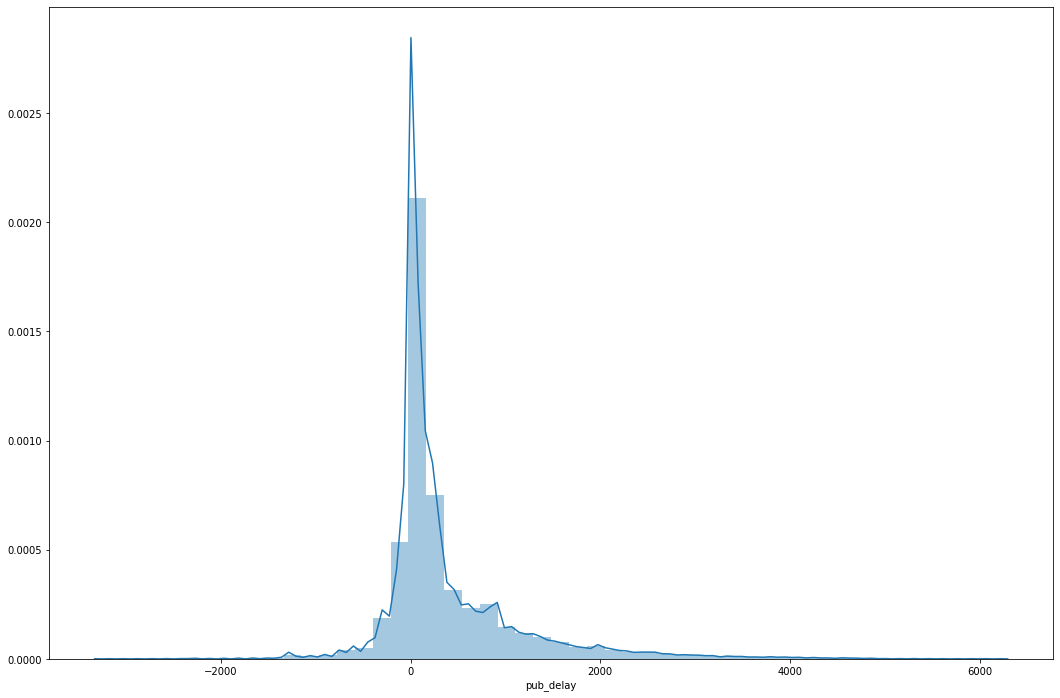

In [9]:
# plot timedelta distribution
fig_dims = (18,12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(gens['pub_delay'], ax = ax)

In [10]:
# select only papers in a reasonable timedelta window

DELAY_MIN = -180
DELAY_MAX = 180

gens_filtered = gens.loc[gens['pub_delay'] <= DELAY_MAX, :].loc[gens['pub_delay'] >= DELAY_MIN, :]
gens_filtered

,journal,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,today,time_public,reuse_count,norm_reuse_count,reuse_role,pub_delay
43390,eLife,PMC5630260,GSE89436,GSE89436,GEO,2017-09-27,2017-03-31,Mus musculus,NaN,NaN,NaN,NaN,NaN,2020-06-22,3.230137,0,0.000000,G,180
214494,PLoS_Genet,PMC4633059,GSE62152,GSE62152,GEO,2015-11-04,2015-05-08,Mycobacterium tuberculosis,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,2020-06-22,5.128767,0,0.000000,G,180
55956,Front_Microbiol,PMC5030273,SRP072068,SRP072068,SRA,2016-09-21,2016-03-25,insect gut metagenome,Illumina MiSeq,WGS,500.0,1.238730e+08,public,2020-06-22,4.246575,0,0.000000,G,180
88071,Heliyon,PMC5968172,SRR6186127,SRP120276,SRA,2018-04-16,2017-10-18,subsurface metagenome,454 GS FLX+,AMPLICON,973.0,2.965432e+07,public,2020-06-22,2.679452,0,0.000000,G,180
114285,ISME_J,PMC6776055,PRJNA506462,SRP170418,SRA,2019-05-30,2018-12-01,wastewater metagenome,Illumina HiSeq 4000,Hi-C,302.0,2.877598e+10,public,2020-06-22,1.558904,0,0.000000,G,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99677,Nat_Commun,PMC4263189,GSE60584,GSE60584,GEO,2014-11-20,2015-05-19,Homo sapiens,NaN,NaN,NaN,NaN,NaN,2020-06-22,5.098630,0,0.000000,G,-180
99676,Nat_Commun,PMC4263189,GSE60586,GSE60586,GEO,2014-11-20,2015-05-19,Homo sapiens,NaN,NaN,NaN,NaN,NaN,2020-06-22,5.098630,2,0.392262,G,-180
175894,Sci_Rep,PMC4844996,PRJNA299423,SRP065141,SRA,2016-04-26,2016-10-23,Escherichia coli,Illumina HiSeq 2500,RNA-Seq,252.0,3.038885e+09,public,2020-06-22,3.665753,0,0.000000,G,-180
114403,ISME_J,PMC5029158,SRR2177920,SRP062709,SRA,2016-01-15,2016-07-13,soil metagenome,Ion Torrent PGM,AMPLICON,166.0,4.152907e+06,public,2020-06-22,3.945205,1,0.253472,G,-180


In [45]:
# select random papers inside/outside threshold for QC analysis
import random

# gens_filtered are inside threshold already
# get papers outside threshold, but within 365 days

DELAY_EDGE = 365

gens_aboveThresh = gens.loc[gens['pub_delay'] >= DELAY_MAX, :].loc[gens['pub_delay'] <= DELAY_EDGE]
gens_aboveThresh = gens_aboveThresh.loc[gens_aboveThresh['repository'] == "GEO", :]
gens_belowThresh = gens.loc[gens['pub_delay'] <= DELAY_MIN, :].loc[gens['pub_delay'] >= -DELAY_EDGE]
gens_belowThresh = gens_belowThresh.loc[gens_belowThresh['repository'] == "GEO", :]
gens_insideThresh = gens_filtered.loc[gens_filtered['repository'] == "GEO", :]

num_papers = 50
half_papers = int(num_papers / 2)

rand_in = pd.DataFrame(random.sample(gens_insideThresh['pmc_ID'].tolist(), num_papers))
rand_in.columns = ['pmc_ID']
rand_ab = pd.DataFrame(random.sample(gens_aboveThresh['pmc_ID'].tolist(), half_papers))
rand_ab.columns = ['pmc_ID']
rand_be = pd.DataFrame(random.sample(gens_belowThresh['pmc_ID'].tolist(), half_papers))
rand_be.columns = ['pmc_ID']

r_in = pd.merge(rand_in, gens_insideThresh[['pmc_ID', 'accession']], on = 'pmc_ID', how = 'left').drop_duplicates()
r_in['real_introducer'] = np.NaN
r_ab = pd.merge(rand_ab, gens_aboveThresh[['pmc_ID', 'accession']], on = 'pmc_ID', how = 'left').drop_duplicates()
r_be = pd.merge(rand_be, gens_belowThresh[['pmc_ID', 'accession']], on = 'pmc_ID', how = 'left').drop_duplicates()
r_out = pd.concat([r_ab, r_be])
r_out['real_introducer'] = np.NaN

r_in.to_csv('../data_tables/randomIntroducers_INSIDE.csv', index = False)
r_out.to_csv('../data_tables/randomIntroducers_OUTSIDE.csv', index = False)

In [12]:
not_gens = allFactors.loc[allFactors['reuse_role'] != 'G', :]
filtered_matrix = pd.concat(objs = [gens_filtered, not_gens], ignore_index = True, sort = False)
filtered_matrix

,journal,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,today,time_public,reuse_count,norm_reuse_count,reuse_role,pub_delay
0,eLife,PMC5630260,GSE89436,GSE89436,GEO,2017-09-27 00:00:00,2017-03-31,Mus musculus,NaN,NaN,NaN,NaN,NaN,2020-06-22,3.230137,0,0.000000,G,180.0
1,PLoS_Genet,PMC4633059,GSE62152,GSE62152,GEO,2015-11-04 00:00:00,2015-05-08,Mycobacterium tuberculosis,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,2020-06-22,5.128767,0,0.000000,G,180.0
2,Front_Microbiol,PMC5030273,SRP072068,SRP072068,SRA,2016-09-21 00:00:00,2016-03-25,insect gut metagenome,Illumina MiSeq,WGS,500.0,1.238730e+08,public,2020-06-22,4.246575,0,0.000000,G,180.0
3,Heliyon,PMC5968172,SRR6186127,SRP120276,SRA,2018-04-16 00:00:00,2017-10-18,subsurface metagenome,454 GS FLX+,AMPLICON,973.0,2.965432e+07,public,2020-06-22,2.679452,0,0.000000,G,180.0
4,ISME_J,PMC6776055,PRJNA506462,SRP170418,SRA,2019-05-30 00:00:00,2018-12-01,wastewater metagenome,Illumina HiSeq 4000,Hi-C,302.0,2.877598e+10,public,2020-06-22,1.558904,0,0.000000,G,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161810,Saudi_J_Biol_Sci,PMC5851940,GSM107072,GSE1456,GEO,2017-11-20,2006-05-31,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,14.071233,269,19.117017,R,NaN
161811,Saudi_J_Biol_Sci,PMC5851940,GSM107231,GSE1456,GEO,2017-11-20,2006-05-31,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,14.071233,269,19.117017,R,NaN
161812,Saudi_J_Biol_Sci,PMC6088103,GSE29378,GSE29378,GEO,2018-05-18,2013-06-07,Homo sapiens,oligonucleotide beads,Expression_Array,NaN,NaN,NaN,2020-06-22,7.046575,15,2.128694,R,NaN
161813,Saudi_J_Biol_Sci,PMC6088103,GSE28146,GSE28146,GEO,2018-05-18,2011-08-01,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,2020-06-22,8.898630,32,3.596059,R,NaN


In [13]:
filtered_matrix.to_csv('../data_tables/metadataMatrix_filtered.csv', index = False)